# Using quantum annealing on Amazon Braket for price optimization

Combinatorial Optimization is one of the most important fields in optimization. Practical applications can be found in virtually every industry. Prominent examples include supply chain optimization in transport and logistics, portfolio management in finance, and the optimization of clinical trials in healthcare, among many others. It is also one of the most active research topics in operation research and computer science. However, many practical combinatorial optimization problems are NP-hard and require massive computation costs to find solution of good quality. 

In this notebook, we demonstrate how a quantum annealer on Amazon Braket can be used for price optimization taking into consideration the trade-off between maximizing revenue and minimizing risk. We show how to formulate this problem as a quadratic unconstrained binary optimization problem (QUBO) and use the D-Wave Advantage quantum annealer on Amazon Braket to find close-to-optimal solutions. Overall, this notebook demonstrates that customers can easily leverage quantum computing through Amazon Braket to solve difficult combinatorial optimization challenges in their daily decision-making process.

# Table of contents
### 1. Demand model
    1. Create demand dataset
    2. Fit demand model through linear regression
### 2. Price optimization with QUBO
    1. Construct revenue objective
    2. Add penalty for prediction uncertainty
    3. Add equality constraints
### 3. Solve QUBO with Amazon Braket
    1. Evaluate results
### 4. Trade-off between revenue expectation and prediction uncertainty
### 5. Conclusion
### 6. Literature review
-----------------

We start by importing important libraries related to Amazon braket and installing dependencies.

In [1]:
!pip install sklearn

In [2]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from pyqubo import Binary
# magic word for producing visualizations in notebook
%matplotlib inline
import time
import reprlib
from collections import defaultdict
from itertools import combinations
import math
import networkx as nx
import dwave_networkx as dnx
import minorminer
import dimod
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from qubo_dynamic_pricing import optimize

np.random.seed(0)
repr_compact = reprlib.Repr()
repr_compact.maxother=200

__NOTE__: Enter your S3 bucket and key below. 

In [3]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-Your-Bucket-Name" # the name of the bucket
my_prefix = "Your-Folder-Name" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [4]:
# session and device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")
print('Device:', device)

Device: Device('name': Advantage_system4.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system4)


# 1. Demand model

The usual goal of price optimization is to maximize the revenue in the next certain period with respect to the corresponding prices, where the revenue can usually be represented by a function of demand and price: 

$$\max_{{\mathbf{p}}} R(\mathbf{p}) = \sum_{t=T}^{T+n-1}d_tp_t$$

where $p_t$ and $d_t$ are the price and demand at day $t$.

In order to do price optimization, we need to create a demand model to estimate demand by a function of price: $d_t=f(\mathbf{p}_t)$, where $\mathbf{p}$ is a vector of latest prices. In such a way, the revenue objective can be transformed as a function solely depending on price to do optimization $R=\sum_{t=T}^{T+n-1}f(\mathbf{p_t})p_t$.

## 1.1 Create training dataset

For simplicity, we create a dummy dataset on historical demand and price observations so that a demand estimation model can be trained.  

Here we assume the true demand at day $d_t$ follows a linear model of the latest $n$ days' prices $p_i, i\in [t-n+1, t-n+2, \ldots, t]$ plus a noise following normal distribution $\varepsilon\sim N(0,\sigma) $.

Thus the demand at day $t$ would be
$$d_t = \sum_{i=t-n+1}^{t}a_{i+n-1-t}p_{i} + b + \varepsilon $$
where $a_j, j\in [0, 1, \ldots, n-1]$ is the elasiticity between the price at day $j+t-n+1$ and demand at day $t$, and
$b$ is a constant.

We use these assumptions to create our dummy training dataset.

In [5]:
a0=[-0.3, -0.5, -1.0, -2.0, -3.0, -3.3, -3.5]  # elasticities in linear demand model
b0=300  # constants in the linear demand model 
sigma=10. # the standard deviation of the noise
price_levels=[5, 8, 10, 12, 13, 16, 19] # predefined possible prices for each day
probabilities=[0.3, 0.3, 0.2, 0.05, 0.05, 0.05, 0.05]  # the probabilities of taking a price choice at a day
n_samples=1000  # the number of sample we want to create

def create_data_point(p, a, b, sigma):
    """
    estimate the demand
    :param p: np.array, (T,)
    :param a: np.array, (T,)
    :param b: float, the constants
    :return: v
    """
    v = np.dot(p,a) + b + np.random.normal(loc=0.0, scale=sigma)
    return v

def create_dataset(a, b, N, price_levels, probabilities, sigma):
    """
    create a dataset for training the demand model
    :param a: np.array, (T,)
    :param b: float
    :param N: int number of samples
    :param price_levels: list, price levels
    :param probabilities: list, probabilities distribution of the prices
    :return:
    """
    t = len(a)
    prices = np.random.choice(price_levels, N+t-1, p=probabilities)
    data_x = []
    data_y = []
    for i in range(N):
        p = prices[i:i+t]
        v = create_data_point(p, a, b, sigma)
        data_x.append(
            np.expand_dims(p, axis=0)
        )
        data_y.append(v)

    data_x = np.concatenate(data_x,axis=0)
    return data_x, data_y

data_x, data_y = create_dataset(a0, b0, n_samples, price_levels, probabilities, sigma)

print("dataset x first 10 samples:")
print(data_x[:10])
print("dataset y first 10 samples:")
print(data_y[:10])

dataset x first 10 samples:
[[ 8 10 10  8  8 10  8]
 [10 10  8  8 10  8 13]
 [10  8  8 10  8 13 19]
 [ 8  8 10  8 13 19  8]
 [ 8 10  8 13 19  8 10]
 [10  8 13 19  8 10  8]
 [ 8 13 19  8 10  8  8]
 [13 19  8 10  8  8 16]
 [19  8 10  8  8 16  5]
 [ 8 10  8  8 16  5  5]]
dataset y first 10 samples:
[176.60983362005817, 166.3135122384355, 122.40886555130055, 139.82753849065216, 136.5494478345374, 139.08672451958816, 171.1141344886614, 149.02456906069798, 153.67576697932017, 185.92865845385478]


## 1.2. Fit the demand model

We use `sklearn` to fit a linear demand model to the training set. This fitted linear demand model will be used for the following price optimization problem.

In [6]:
def linear_regression(data_x, data_y):
    reg = LinearRegression().fit(data_x, data_y)
    a = reg.coef_
    b = reg.intercept_
    return a, b


a, b = linear_regression(data_x, data_y)
a = [i for i in a]
b = b

print(f'fitted elasticities: {a}')
print(f'fitted constant: {b}')

fitted elasticities: [-0.3779074420638822, -0.5723441150118157, -0.8832936349398142, -2.044653528191526, -2.9861902495686956, -3.2337479564086022, -3.6095730899274248]
fitted constant: 301.2623906306577


# 2. Price optimization with QUBO

In this notebook, we leverage a general-purpose mathematical framework: Quadratic Unconstrained Binary Optimization (QUBO), which has been recently proposed as an effective framework that is able to generalize across a large variety of combinatorial optimization use cases in industries [2, 3]. We take this price optimization as an example and showcase how to formulate it into QUBO framework considering prediction uncertainties as well as equality constraints.

The formal definition of QUBO is expressed as an optimization problem, Minimize:
$$H=x^TQx$$

where $x$ is a vector of binary variables representing the decision variables of the combinatorial optimization. $Q$ is a squared matrix of constants inherently encoding the context and constraints of the optimization problems. $Q$ is commonly assumed to be symmetric or upper triangular without loss of generality. The goal is to find the optimal values of the binary decision variables $x$ that minimize the objective $H$.

As shown above, the format of QUBO is strikingly simple, providing a general-purpose framework for a large class of combinatorial optimization problems. Below we show how to transform the objective function together with the constraints into this QUBO format. 

## 2.1 Construct objective function

Assuming tomorrow is day $T$, then the goal of our price optimization is to find the optimal prices $p_t, t\in[T, T+1, \ldots, T+n-1]$ in the next $n$ days in order to maximize the revenue in next $n$ days. Based on the demand model we showed above where the demand at a day is correlated with the latest $n$ days' price, we can construct objective function as below:

$$\max_{{\mathbf{p}}}R(\mathbf{p})=\sum_{t=T}^{T+n-1}d_tp_t$$

where $d_t$ is represented by our fitted model above: $d_t = \sum_{i=t-n+1}^{t}a_{i+n-1-t}p_{i} + b $

Therefore, we need at least the most recent n days historical prices. Here we randomly choose a historical range of $n$ days' prices as the most recent price data.  

In [7]:
p_data = data_x[np.random.randint(0,n_samples)].tolist()

p_data

[10, 8, 8, 5, 5, 8, 8]

Now, let's construct the objective function, i.e. the total revenue $R$, for the next $n$ days.

First, we need to define the price variable $p_t$. According to certain business requirements, the possible prices are usually defined to be a set of discrete price values (e.g. \\$5.99, \\$9.99, \\$14.99).  This means the price at each day only has a set of fixed available $m$ options $c_k, k \in [0, 1, \ldots, m-1]$, we can represent the price $p_t$ at day $t$ as: $$p_t=\sum_{k=0}^{m-1}c_{k}x_{t,k}, \textrm{ subject to } \sum_{k=0}^{m-1}x_{t,k}=1$$ 

where $x_{t,k}$ is a binary variable with $1$ meaning the price at day $t$ takes option $c_k$, and $0$ meaning otherwise. Therefore, we can use binary variables $x_{t,k}$ to represent the price variables $p_t$.

In [8]:
# here, we use a list to represent the sequence of prices from day T-n to day T+n-1.

t = len(a) # next number of days to optimize
n_level = len(price_levels)  # number of price options

x = []
p = []

# get p
for i in range(t):
    p_i = 0
    for j in range(n_level):
        x_ij = Binary(f"X_{i*n_level+j:03d}")
        x.append(x_ij)
        p_i += x_ij*price_levels[j]
    p.append(p_i)
    
# plus historical prices
all_p = p_data + p

all_p

[10,
 8,
 8,
 5,
 5,
 8,
 8,
 (Binary(X_006)*Num(19.000000)+Binary(X_005)*Num(16.000000)+Binary(X_004)*Num(13.000000)+Binary(X_003)*Num(12.000000)+Binary(X_002)*Num(10.000000)+Binary(X_000)*Num(5.000000)+Binary(X_001)*Num(8.000000)),
 (Binary(X_013)*Num(19.000000)+Binary(X_012)*Num(16.000000)+Binary(X_011)*Num(13.000000)+Binary(X_010)*Num(12.000000)+Binary(X_009)*Num(10.000000)+Binary(X_007)*Num(5.000000)+Binary(X_008)*Num(8.000000)),
 (Binary(X_020)*Num(19.000000)+Binary(X_019)*Num(16.000000)+Binary(X_018)*Num(13.000000)+Binary(X_017)*Num(12.000000)+Binary(X_016)*Num(10.000000)+Binary(X_014)*Num(5.000000)+Binary(X_015)*Num(8.000000)),
 (Binary(X_027)*Num(19.000000)+Binary(X_026)*Num(16.000000)+Binary(X_025)*Num(13.000000)+Binary(X_024)*Num(12.000000)+Binary(X_023)*Num(10.000000)+Binary(X_021)*Num(5.000000)+Binary(X_022)*Num(8.000000)),
 (Binary(X_034)*Num(19.000000)+Binary(X_033)*Num(16.000000)+Binary(X_032)*Num(13.000000)+Binary(X_031)*Num(12.000000)+Binary(X_030)*Num(10.000000)+Bina

Next, we can input the price variables into our fitted model to estimate the demand, and then use the demand together with the price to represent the revenue $R$.

In [9]:
def get_demand(coeff, b, prices):
    assert len(coeff) == len(prices)
    d = b
    for i in range(len(coeff)):
        d += coeff[i]*prices[i]

    return d

# get d, rev
def get_demands_rev(a,b,hist_p, p):
    """ represent the next n days demands and total revenue, based on:
        1. the fitted coefficients a,b
        2. the historical price hist_p
        3. and the future price decisions represented by binary variable x
    """
    all_p = hist_p + p
    t = len(a)
    d = [get_demand(
            coeff=a,
            b=b,
            prices=all_p[i+1:i+1+t]
        ) for i in range(t)]
    rev = np.dot(d, p)
    return d, rev

d, rev = get_demands_rev(a,b,p_data, p)

print('Revenue:')
repr_compact.repr(rev)

Revenue:


'(((Binary(X_048)*Num(19.000000)+Binary(X_047)*Num(16.000000)+Binary(X_046)*Num(13.000000)+Binary(X...m(12.000000)+Binary(X_009)*Num(10.000000)+Binary(X_007)*Num(5.000000)+Binary(X_008)*Num(8.000000)))'

## 2.2 Add penalty for prediction uncertainty

In optimization, we usually desire to reduce the risk while maximizing the reward, which means we want to reduce the estimated uncertainty/variance of the predicted demands. Therefore, we add a penalty term in the objective function to represent the uncertainty of the predicted demand. The uncertainty of the predicted demand $d_t$ can be represented by its estimated variance,

$$H=Revenue-\beta\sum_{t=T}^{T+n-1}var(d_t)$$

where $\beta$ is the regularization parameter to control the effect of risk estimation. The variance of the demand predictions can be estimated as [10]: $$var(d_t)=\sigma^2(1+\vec{p}_t'(\vec{X}'\vec{X})^{-1}\vec{p}_t)$$

where $\vec{p}_t'=[1, p_{t-n+1},p_{t-n+2}, \ldots,p_{t}]$ is the price vector to estimate demand $d_t$. $\vec{X}$ are the observations in the training dataset used to fit the demand model, where each row is an observation in the training set.

$$\vec{X} = \left[
    \begin{matrix}
      1 & p_{0,1} & p_{1,1} & \dots & p_{n-1,1}\\
      1 & p_{0,2} & p_{1,2} & \dots & p_{n-1,2}\\
      \vdots& \vdots& \vdots&& \vdots\\
      1 & p_{0,N}& p_{1,N}& \dots& p_{n-1,N}
    \end{matrix}\right].$$

In [10]:
beta=1.

def get_variance(data_x, p, sigma):
    """
    :param data_x (np.array): [n_samples, n_days]
    :param p (list): [n_days]
    :return: variance
    """
    n_samples, t = data_x.shape
    ones = np.ones((n_samples, 1), dtype=np.float)
    x_mat = np.concatenate([ones, data_x], axis=1)  # [n_samples, n_days+1]
    x_mat = np.linalg.inv(
        np.dot(x_mat.T, x_mat)
    )
    p = np.array([1.]+p)
    variance = (sigma**2) * (1. + p.dot(x_mat).dot(p))
    return variance

def get_overall_variance(data_x, hist_p, p, sigma):
    all_p = hist_p + p
    t = len(p)
    var = 0
    for i in range(t):
        var += get_variance(data_x, all_p[i+1:i+1+t], sigma)

    return var

objective = rev - beta * get_overall_variance(data_x, p_data, p, sigma)

repr_compact.repr(objective)

'((((Binary(X_048)*Num(19.000000)+Binary(X_047)*Num(16.000000)+Binary(X_046)*Num(13.000000)+Binary(...X_001)*Num(8.000000))*Num(-0.000535)+Num(0.016381))+Num(1.000000))*Num(100.000000))*Num(-1.000000))'

## 2.3 Add penalty for equality constraints

Since the price can only take one value per day, exactly one of the binary variables in a day must be $1$, and the others must be $0$. Formallly, we have equality constraints:
$$\sum_{k=0}^{m-1}x_{t,k}=1, \;t\in[T, T+1, \cdots, T+n-1]$$

We can easily incorporate this equality constraint into the objective function by substracting a penalty term $H_p$ with large enough coefficient $L_p$. If the solution satisfies these constraints, the penalty term will be 0, otherwise a large penalty will be imposed.

$$H_p=L_p\sum_{t=T}^{t=T+n-1}[(\sum_{k=0}^{m-1}x_{t,k})-1]^{2}$$

In [11]:
# add equalty constraints
Lp=1e13

for i in range(t):
    penalty_i = ((sum(x[i*n_level:(i+1)*n_level]) - 1)**2)*Lp
    objective -= penalty_i
    
repr_compact.repr(objective)

'(((((((((((Binary(X_048)*Num(19.000000)+Binary(X_047)*Num(16.000000)+Binary(X_046)*Num(13.000000)+...nary(X_044)+Binary(X_042)+Binary(X_043))+Num(-1.000000))*Num(10000000000000.000000)*Num(-1.000000))'

# 3. Solve QUBO with Braket

Now we have transformed to the total objective function which:
- maximizes the revenue 
- minimizes the prediction uncertainty 
- incorporates equality constraints, $\sum_{k=0}^{m-1}x_{t,k}=1, \;t\in[T, T+1, \cdots, T+n-1]$  

$$H=Revenue-\beta\sum_{t=T}^{T+n-1}var(d_t) - H_p $$
where $H_p=L_p\sum_{t=T}^{t=T+n-1}[(\sum_{k=0}^{m-1}x_{t,k})-1]^{2} $ is the penalty term for price equality constraints, and $L_p$ is a constant.

We can transform this objective function to binary quadratic model, and solve it using Amazon Braket.

Amazon Braket provides access to quantum annealers from D-Wave Systems Inc. which are specifically designed to solve QUBO problems. A quantum annealer is a hardware implementation of Quantum Annealing (QA) which is a generic algorithm to solve combinatorial optimization problems by taking advantage of quantum fluctuations to escape local minima in complex energy landscapes by effect of tunnelling through barriers separating local minima [5].  Through a simple Amazon Braket API call, the formatted QUBO problem can be embedded to the hardwired topology of the machine and submitted to machine. In turn, the quantum annealer performs an annealing process and obtains a result. However, because of the sparsity of the underlying chip, one typically faces a certain overhead in embedding the original QUBO problem to the D-Wave hardware, because (typically) one logical binary variable maps onto several physical qubits, in order to effectively distill the connectivity of the original QUBO problem. For more details, we refer to the Amazon Braket tutorial notebook available here (https://github.com/aws/amazon-braket-examples/blob/main/examples/quantum_annealing/Dwave_Anatomy.ipynb).

In [12]:
model = (-objective).compile().to_bqm()

repr_compact.repr(model)

"BinaryQuadraticModel({X_005: -10000000002744.719, X_030: -10000000002576.855, X_036: -100000000021...', 'X_026'): 572.3665512211251, ('X_026', 'X_013'): 906.2470394334479}, 70000000000715.1, 'BINARY')"

In [13]:
len(model)

49

We embed and submit the QUBO task to be solved by a quantum annealer at D-wave backend. Similar to classical simulated annealing, we take several independent shots in order to increase our chances for success in finding a high-quality solution to the QUBO problem. The response contains a number of rows. Each row represents the optimization result of a single shot, including the binary decision variables $[x_T,\cdots,x_{T+n-1}]$, and corresponding energy which is the negative value of objective function, i.e. $H$. Below we show how to submit a QUBO problem to D-Wave and provide a sample response. Here, the key figure of merit is listed in the column labelled with energy, representing the value for the objective function . We can then easily read off the best bit string found.

Each row represents an optimized solution. The columns starting with `X_` show the value of the binary decision variables $x_{t,k}$ and the `energy` column shows the negative value of the objective function, i.e. $-H$

In [15]:
## run dwave quantum annealing
num_shots = 10000

sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/Advantage_system4')
sampler = EmbeddingComposite(sampler)
response = sampler.sample(model, num_reads=num_shots)

# print results
results_df = response.to_pandas_dataframe()
results_columns = results_df.columns[results_df.columns.str.startswith('X_')].tolist()
results_columns += ['energy']

results_df[results_columns].sort_values('energy').head()

,X_000,X_001,X_002,X_003,X_004,X_005,X_006,X_007,X_008,X_009,...,X_040,X_041,X_042,X_043,X_044,X_045,X_046,X_047,X_048,energy
76,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,-12752.164062
914,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,-12602.234375
1331,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-12597.156250
77,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-12589.992188
78,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-12555.671875


## 3.1 Evaluate the results

With the response, we can decode the binary array results into the optimal price results

In [16]:
def decoder_price_response(response, n_days, price_options):
    opt_price, energy = response.record.sample[response.record.energy.argmin()], response.record.energy.min()
    prices = []
    for i in range(n_days):
        price_i = opt_price[i*len(price_options): (i+1)*len(price_options)]
        assert price_i.sum()==1
        prices.append(price_options[price_i.argmax()])
    return prices, opt_price, energy

opt_decoded_prices, opt_prices, energy =decoder_price_response(response, len(a), price_levels)

opt_decoded_prices, opt_prices, energy

([13, 13, 12, 5, 10, 19, 19],
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1], dtype=int8),
 -12752.1640625)

The optimized price path and corresponding demand curve are plotted below, respectively. The optimal price level is higher than the past 7 days, which results in the demand decreasing.

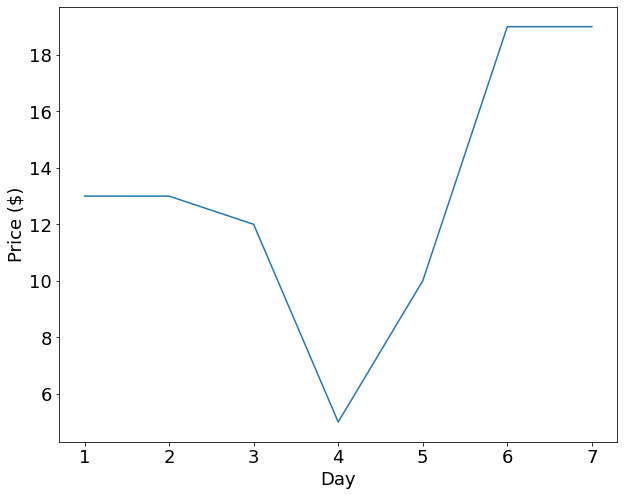

In [17]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,8))
plt.plot(range(1,8),opt_decoded_prices)
plt.xlabel('Day')
plt.ylabel('Price ($)')
plt.savefig('price_path.png')

Let's also calculate the total revenue, and plot the demand of each day.

In [18]:
opt_d, max_rev = get_demands_rev(a,b,p_data, opt_decoded_prices)

opt_d, max_rev

([182.33668654152052,
  161.75101851993844,
  148.9134817833946,
  165.47394138330202,
  167.4983113772031,
  138.92967848592662,
  108.20132675236677],
 13457.943867415815)

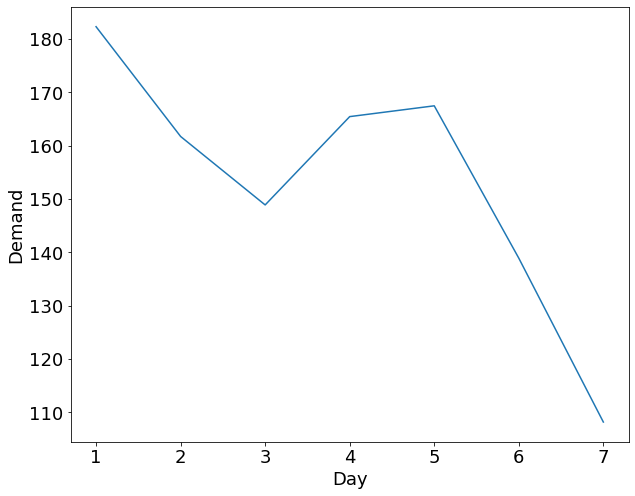

In [19]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,8))
plt.plot(range(1,8),opt_d)
plt.xlabel('Day')
plt.ylabel('Demand')
plt.savefig('demand_path.png')

Finally, let's get the overall uncertainty of the demand predictions. Here we simply use the estimated demand variance to indicate the uncertainty.

In [20]:
overall_variance = get_overall_variance(data_x, p_data, opt_decoded_prices, sigma)

overall_variance

705.7816180128258

__We can also derive the standard deviation of the revenue based on the variance of demand__

$$std(R)=\sqrt{(\sum_{t=T}^{T+n-1}var(\hat{d}_t)*p_t^2) + \sum_{t_1, t_2\in [T,\ldots,T+n-1] \\ t_1!=t_2}2p_{t_1}p_{t_2}cov(\hat{d}_{t_1} \hat{d}_{t_2}) }$$

where $cov(\hat{d}_{t_1} \hat{d}_{t_2}) = \sigma^2(1+\vec{p}_{t_1}'(\vec{X}'\vec{X})^{-1}\vec{p}_{t_2})$

In [21]:
def get_covariance(data_x, p1, p2, sigma):
    """
    :param data_x (np.array): [n_samples, n_days]
    :param p1, p2 (list): [n_days]
    :return: variance
    """
    n_samples, t = data_x.shape
    ones = np.ones((n_samples, 1), dtype=np.float)
    x_mat = np.concatenate([ones, data_x], axis=1)  # [n_samples, n_days+1]
    x_mat = np.linalg.inv(
        np.dot(x_mat.T, x_mat)
    )
    p1 = np.array([1.] + p1)
    p2 = np.array([1.] + p2)
    variance = (sigma**2) * (1. + p1.dot(x_mat).dot(p2))
    return variance

def get_overall_revenue_variance(data_x, hist_p, p, sigma):
    all_p = hist_p + p
    t = len(p)
    var = sum([get_variance(data_x, all_p[i+1:i+1+t], sigma) * (p[i]**2) for i in range(t)])
    
    # add covariance
    var += sum([
        get_covariance(
            data_x,
            all_p[i + 1:i + 1 + t],
            all_p[j + 1:j + 1 + t],
            sigma
        ) * 2 * p[i] * p[j] for i, j in combinations(list(range(t)), 2) 
    ])

    return var

revenue_variance = get_overall_revenue_variance(data_x, p_data, opt_decoded_prices, sigma)

np.sqrt(revenue_variance)

911.7464747275401

We can investigate the value of the penality terms to see if any equality constraints are violated. The penalty is close to zero showing that all the constraints are satisfied. This small but non-zero value is due to floating point precision.

In [22]:
penalty = max_rev - beta*overall_variance + energy

penalty

-0.0018130970111087663

For comparison, to assess the quality of this optimized result, we also iterate (by brute-force search) through all the $7^7=823,543$ possible price solutions to obtain the energy for each one, which takes more than 5 minutes to run on a standard ml.m5.2xlarge AWS instance. We plot the distribution of the energies of all the 823,543 possible solutions as shown below, where the red line represents our optimized result obtained from the quantum annealer. We can see that although the optimized result from the quantum annealer is not the global optimum with minimum cost, it is close-to-optimal and of good quality. 

In [23]:
all_rev=[]
all_var=[]
all_energy=[]
i=0

for p_t1 in price_levels:
    for p_t2 in price_levels:
        for p_t3 in price_levels:
            for p_t4 in price_levels:
                for p_t5 in price_levels:
                    for p_t6 in price_levels:
                        for p_t7 in price_levels:
                            if i%1000==0:
                                print(i)
                                
                            _, sample_rev = get_demands_rev(a,b,p_data, [p_t1,p_t2,p_t3,p_t4,p_t5,p_t6,p_t7])
                            sample_overall_variance = get_overall_variance(data_x, p_data, [p_t1,p_t2,p_t3,p_t4,p_t5,p_t6,p_t7], sigma)
                            all_rev.append(sample_rev)
                            all_var.append(sample_overall_variance)
                            all_energy.append(-(sample_rev-beta*sample_overall_variance))
                            i+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


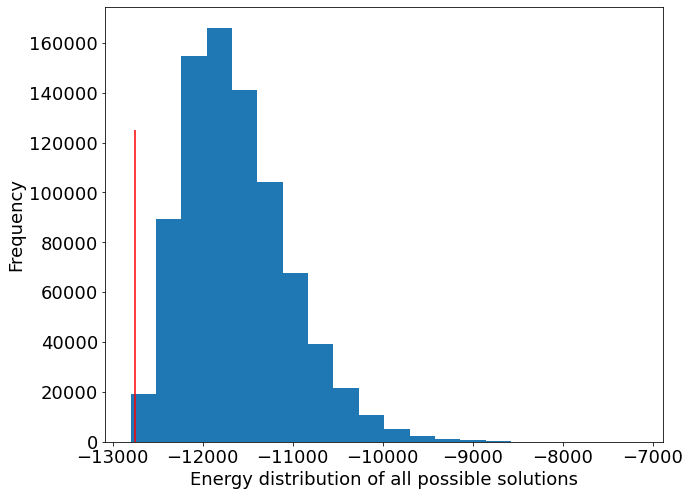

In [24]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,8))
plt.vlines(energy,0,125000, 'r')
plt.hist(all_energy,20)
plt.xlabel('Energy distribution of all possible solutions')
plt.ylabel('Frequency')
plt.savefig('result_quality.png')

# 4. Trade-off between expected revenue and prediction uncertainty.

Let's first wrap the above price optimization into a single optimize function for convenience.

In [25]:
Ld=1e6

max_revenue, prediction_variance, energy, opt_demand, opt_prices, rev_std = optimize(
    a = a,
    b = b,
    data_x = data_x,
    selected_hist_prices = p_data,
    price_levels = price_levels,
    Lp = Lp,
    Ld = Ld,
    sigma = sigma ,
    beta=beta,
    vol_bound=None,
    s3_folder=s3_folder
)

max_revenue, prediction_variance, energy, opt_demand, opt_prices, rev_std

(13362.364731002446,
 706.7208258596746,
 -12655.6484375,
 [185.94625963144793,
  154.15604720656478,
  167.46543979322945,
  155.9292482281557,
  160.514740479689,
  130.2613846464788,
  98.73268259663321],
 [12, 16, 5, 12, 10, 19, 19],
 931.8876101527734)

In order to investigate the trade-off between the expected revenue and prediction uncertainties, we vary the hyperparameter $\beta$ within a large range of $[1e2,1e9]$ and run multiple experiments on D-Wave with different $\beta$ values. The scatter plot is shown below, where each dot represents the optimized result of an experiment with x-axis representing its expected revenue and y-axis representing the estimated standard deviation of revenue $std(R)$.

<div class="alert alert-block alert-warning">
<b>Caution:</b> Running the following cell will run a substantial amount of tasks for various senarios taking about 30 minutes. Only uncomment it if you are happy to wait.
</div>

In [26]:
#beta_options=[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]
#results = {beta_option:[] for beta_option in beta_options}
#beta_samples = beta_options*6

#for beta_i in beta_samples:
#    max_revenue, prediction_variance, energy, opt_demand, opt_prices, rev_std = optimize(
#        a = a,
#        b = b,
#        data_x = data_x,
#        selected_hist_prices = p_data,
#        price_levels = price_levels,
#        Lp = Lp,
#        Ld = Ld,
#        sigma = sigma ,
#        beta=beta_i,
#        vol_bound=None,
#        s3_folder=s3_folder
#    )
#    print('---')
#    print(f"beta_sample:{beta_i}")
#    print(f"max_revenue:{max_revenue}")
#    print(f"prediction_variance:{prediction_variance}")
#    print(f"energy:{energy}")
#    print(f"opt_demand:{opt_demand}")
#    print(f"opt_prices:{opt_prices}")
#    print(f"rev_std: {rev_std}")
#    print(f"penalty_term: {max_revenue-beta_i*prediction_variance+energy}")
#    results[beta_i].append([energy, max_revenue, prediction_variance, rev_std])

---
beta_sample:100.0
max_revenue:13142.782268581876
prediction_variance:703.5502036738326
energy:57212.2421875
opt_demand:[182.33668654152052, 179.79888396957557, 165.08222156543758, 155.1378810016535, 155.08534332330055, 154.92897272299166, 125.8542042377626]
opt_prices:[13, 8, 12, 12, 10, 10, 19]
rev_std: 840.9865848076566
penalty_term: 0.004088698617124464
---
beta_sample:1000.0
max_revenue:13198.22244328534
prediction_variance:702.9415585415351
energy:689743.3359375
opt_demand:[193.16540581130278, 182.28098165894653, 163.96372331139906, 159.28485931053694, 157.1272228349854, 151.58799858923842, 122.5817558425566]
opt_prices:[10, 10, 13, 10, 10, 12, 19]
rev_std: 841.0012457923974
penalty_term: -0.0001607497688382864
---
beta_sample:10000.0
max_revenue:11976.233040996605
prediction_variance:702.6893930180825
energy:7014917.6953125
opt_demand:[185.94625963144793, 183.03263192598416, 182.506704174716, 195.38453798497142, 183.33048747152048, 185.3349129647881, 166.23041487017076]
opt_p

We can see from the plot below that there is a Pareto front [11] where the expected revenue cannot be increased without increasing the standard deviation (i.e. uncertainties), and the other way around.

We can see that the expected revenue can vary significantly between 10000 and 13500, while the estimated standard deviation of the revenue (i.e. uncertainty) can change in a large range $[200,380]$ as well. The figure shows that as the expected revenue increases, the estimated standard deviation of the revenue will also increase. This means that if we select a price solution for higher expected revenue, the uncertainties will increase at the same time indicating that the demand estimation model will become less confident about its predictions. This illustrates there is a trade-off between maximizing the revenue and minimizing the uncertainty. High revenue and rewards usually accompany with high uncertainties and risk. In practice, according to different business strategies and needs, we usually need to find an appropriate $\beta$ to maximize the revenue under an acceptable level of uncertainty.

In [27]:
beta_x=[]
revenue_y=[]
variance_y=[]
rev_std_y=[]

for beta_i in beta_options:
    for result in results[beta_i]:
        beta_x.append(beta_i)
        revenue_y.append(result[1])
        variance_y.append(result[2])
        rev_std_y.append(result[3])

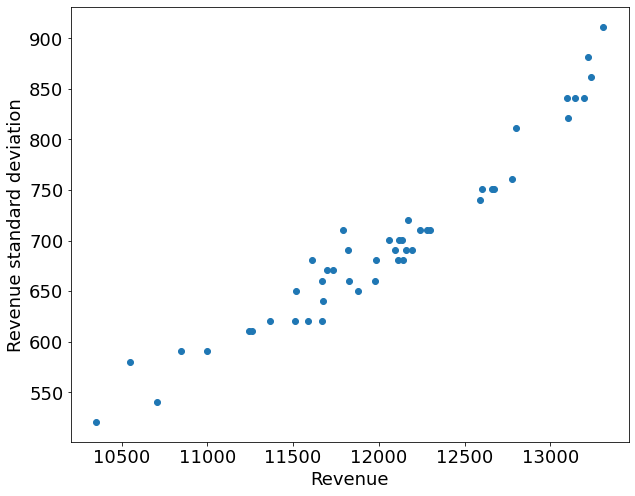

In [28]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,8))
plt.scatter(revenue_y, rev_std_y)
plt.xlabel('Revenue')
plt.ylabel('Revenue standard deviation')
plt.savefig('tradoff_sigma=10_b=300.png')

# 5. Conclusion

In this notebook, we demonstrate how to leverage a quantum annealer on Amazon Braket to solve a price optimization use case. We showed how to mathematically formulate the problem within the (quantum-ready) QUBO framework, and then subsequently solve the optimization problem on a D-Wave quantum annealer. Our results are promising in terms of both close-to-optimal quality and computational efficiency. Since the QUBO formalism is a generalized framework that can embrace a variety of combinatorial optimization use cases (e.g. scheduling/planning, routing, portfolio management), the proposed solution can be arguably adapted and recycled by customers across other multiple industries. Already today our customers can get quantum-ready, and easily leverage Amazon Braket to help solve their daily combinatorial optimization challenges, and make better business and operation decisions.

# 6. References:
1. Glover, F., Kochenberger, G. and Du, Y., 2019. Quantum Bridge Analytics I: a tutorial on formulating and using QUBO models. 4OR, 17(4), pp.335-371.
2. Kochenberger, G., Hao, J.K., Glover, F., Lewis, M., Lü, Z., Wang, H. and Wang, Y., 2014. The unconstrained binary quadratic programming problem: a survey. Journal of combinatorial optimization, 28(1), pp.58-81.
3. Anthony, M., Boros, E., Crama, Y. and Gruber, A., 2017. Quadratic reformulations of nonlinear binary optimization problems. Mathematical Programming, 162(1), pp.115-144.
4. Amazon Web Services. Amazon Braket – Amazon Web Services, 2021. Available at: https://aws.amazon.com/braket/ (Accessed: 15 July, 2021)
5. Cruz-Santos, W., Venegas-Andraca, S.E. and Lanzagorta, M., 2019. A QUBo formulation of Minimum Multicut problem instances in trees for D-Wave Quantum Annealers. Scientific reports, 9(1), pp.1-12.
6. Amazon Web Services. A python SDK for interacting with quantum devices via AWS, 2021. Available at: https://github.com/aws/amazon-braket-sdk-python (Accessed: 16 July, 2021) 
7. Amazon Web Services. Amazon SageMaker – Machine Learning – Amazon Web Services, 2021. Available at: https://aws.amazon.com/sagemaker/ (Accessed: 20 July, 2021)
8. Ben-Tal, A. and Nemirovski, A., 2002. Robust optimization–methodology and applications. Mathematical programming, 92(3), pp.453-480.
9. Fabozzi, F.J., Kolm, P.N., Pachamanova, D.A. and Focardi, S.M., 2007. Robust portfolio optimization and management. John Wiley & Sons.
10. Hyndman, R.J. and Athanasopoulos, G., 2018. Forecasting: principles and practice. OTexts. Available at: https://otexts.com/fpp2/regression-matrices.html (Accessed: 20 July, 2021)
11. Wikipedia. Pareto front - Wikipedia, 2021. Available at: https://en.wikipedia.org/wiki/Pareto_front (Accessed: 21 Dec, 2021)